<a href="https://colab.research.google.com/github/AashiDutt/Pytorch/blob/master/Style_Transfer_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STYLE TRANSFER 
transfering style of 2nd image to the 1st

Image Content + Image Style = Target Image




In [1]:
!pip install torch torchvision
!pip install pillow==4.0.0

     |████████████████████████████████| 5.6MB 3.3MB/s 
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms , models
from PIL import Image  # from pillow import image module
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# using VGG19 pre- trained model

# getting weights /features of vgg19
vgg = models.vgg19(pretrained =True).features

for param in vgg.parameters():
  param.requires_grad_(False)   # freezing weights from being updated by backpropagation


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:37<00:00, 15170551.10it/s]


In [4]:
# using gpu wherever needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

# as we imported only features of vgg19 model 
# thus we cannot see the fully connected layers(belong to classifiers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
# image transforms

def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')# load image from file path
 
    if max(image.size) > max_size:# if size of imaage > 400 pixels 
        size = max_size
    else:
        size = max(image.size)  #image size is smaller than threshold value(400 pixels)
    
    if shape is not None:   #if shape of content image do not match shape of style image
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])
 
    image = in_transform(image).unsqueeze(0)
    
    return image

In [0]:
# uploading images 
# images will be recyled if reuntime is reset in the colab


content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg',shape = content.shape[-2:]).to(device)

In [0]:
# convert images from tensors to numpy images

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  # clone to create new copy of tensor
  # use detach function to call numpy
  
  image = image.transpose(1,2,0)
  # we have shape of tensor as(1,28,28)(single colorchannel,shape(28,28)) but to plot a grayscale image we need tensor of shape (28,28,1)
  # we swap axis using transpose means swap axis 0 for axis 1, axis 1 fo axis 2 and axis 0 in the end
  #print(image.shape)
  # denormalizing the image
  # x=z * standard deviation + mean
  
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  # to reconvert range from (-1,1) to (1,1) we use clip function
  return image

In [0]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
 
    return image

(-0.5, 599.5, 399.5, -0.5)

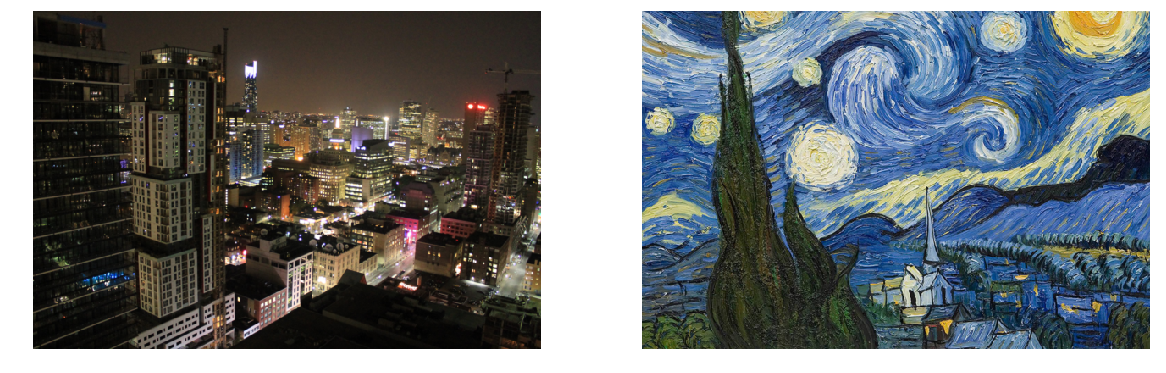

In [10]:
#plotting images

fig, (ax1 ,ax2) = plt.subplots(1 ,2 ,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [0]:
# implementing style transfer by feature extraction

def get_features(image, model):
  # extracting features from selected layers 
  layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1','19': 'conv4_1','21': 'conv4_2','28': 'conv5_1'}

  # using conv4_2 for content extraction rest for style extraction
  
  features ={}  # empty dictionary to store all extracted features
  
  for name,layer in model._modules.items():
    image = layer(image)
    
    if name in layers:
      features[layers[name]] =image
      
  return features
      

In [0]:
content_features =get_features(content,vgg)
style_features =get_features(style,vgg)

In [0]:
# Gram matrix for better feature extraction

# Gram = transpose(V) * V  where V is an arbitrary vector 

def gram_matrix(tensor):
  
  # reshape image tensor from 4 dimensions to 2 dimensions
  
  _,d, h, w =tensor.size()    # depth , height and width to reshape our image tensor
  tensor = tensor.view(d, h*w) # reshaping
  
  # gram matrix
  gram = torch.mm(tensor,tensor.t())  # matrix multiplication of tensor to its transpose
  return gram

In [0]:
style_grams={layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
style_weights ={'conv1_1':1.,'conv2_1': .75 ,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2}

content_weight =1   # alpha
style_weight = 1e6  # 10^6 beta


In [0]:
# target image is a clone of content image

target = content.clone().requires_grad_(True).to(device)


In [0]:
# optimization

show_every = 300  # gives update on target image at every 300 iterations
optimizer = optim.Adam([target], lr =0.003)
steps = 2100

# data visualization
# stores target images through out the training process
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300   # capture frames every 7 steps for video
counter =0


Total loss:  2887760.0
Iterations: 300


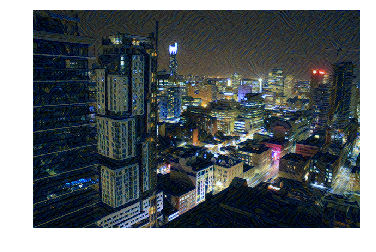

Total loss:  949926.1875
Iterations: 600


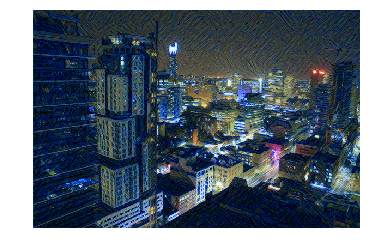

Total loss:  658508.0625
Iterations: 900


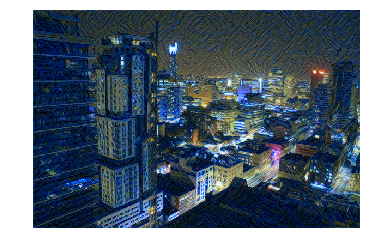

Total loss:  510520.375
Iterations: 1200


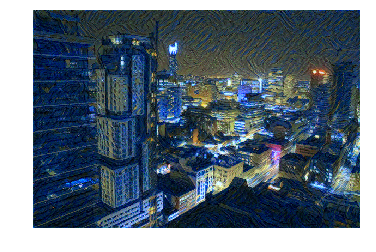

Total loss:  400851.5
Iterations: 1500


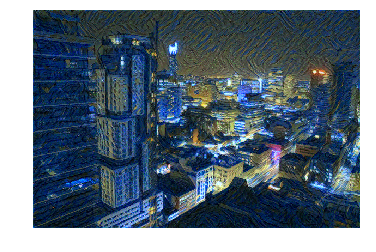

Total loss:  315061.59375
Iterations: 1800


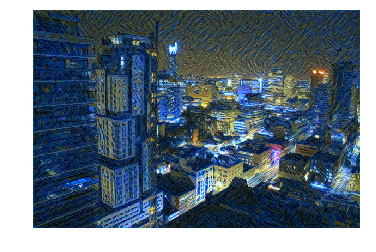

Total loss:  246978.78125
Iterations: 2100


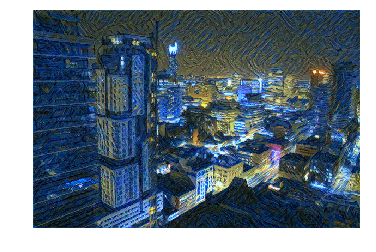

In [27]:
for ii in range(1,steps+1):
  # step 1 collecction of features for target image
  target_features= get_features(target, vgg)
  
  # cal content loss for each iteration
  content_loss = torch.mean((target_features['conv4_2']- content_features['conv4_2'])**2)
  
  # style loss from 5 layers conv1_1 to conv5_1
  style_loss =0
  
  for layer in (style_weights):
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    
    # cal layer style loss
    layer_style_loss =style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    
    # normalize style loss to get unit style loss
    _,d ,h, w =target_feature.shape
    style_loss += layer_style_loss/(d* h * w)
    
  total_loss = content_weight*content_loss + style_weight*style_loss
   
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if ii % show_every ==0:
    print('Total loss: ', total_loss.item())
    print('Iterations:',ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()
    
  if ii % capture_frame ==0:
    image_array[counter] = im_convert(target)
    counter = counter +1

(-0.5, 599.5, 399.5, -0.5)

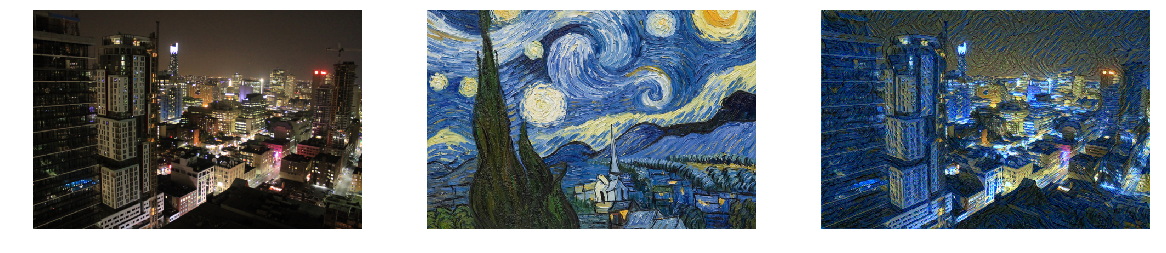

In [28]:
# plotting target image side by side with content and style image
fig, (ax1,ax2 ,ax3) = plt.subplots(1,3,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [0]:
# converting iterations into a visualization video

import cv2

frame_height, frame_width,_=im_convert(target).shape
vid=cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'XVID'),30,(frame_width, frame_height))

for i in range(0, 300):
  img =image_array[i]
  # removing normalization
  img = img * 255
  # converting to numpy array
  img = np.array(img, dtype =np.uint8)
  cv2.cvtColor(img ,cv2.COLOR_BGR2RGB)
  vid.write(img)
  
vid.release()


In [32]:
!ls

City.jpg  MonaLisa.jpg	output.mp4  sample_data  StarryNight.jpg


In [0]:
from google.colab import files
files.download('output.mp4')